# Import Resnet

In [1]:
from keras.applications.resnet50 import ResNet50
conv_base = ResNet50(weights='imagenet',include_top=False,pooling='avg',input_shape=(378,256,3))
conv_base.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 378, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 384, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 189, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 189, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [2]:
import numpy as np
import re
from scipy.io import loadmat
import os
from keras.preprocessing import image 
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
base_dir="/home/ankur248/Documents/Europe/Fashion144k_v1/photos/"

# Fashion Train Labels

In [3]:
relvotes = loadmat('/home/ankur248/Documents/Europe/Fashion144k_v1/feat/relvotes.mat')
relvotes=np.array(relvotes['X'])
print(relvotes)
print(relvotes.shape)

[[10.  2.  1. ...  5.  5.  8.]]
(1, 144169)


# Creating Train Images

In [4]:
f=open("/home/ankur248/Documents/Europe/Fashion144k_v1/photos.txt", "r")

if f.mode == 'r':
    contents =f.read()
            
image_order=[]          
image_order.append(re.findall(r"[-+]?\d*\.\d+|\d+", contents))
image_order=np.array(image_order)
#print(image_order)
#print(image_order.shape)

In [5]:
order=contents.split('\n')
order=np.array(order)

In [6]:
train_split=order[0:3000]
train_labels=relvotes[0][0:3000]
validation_split=order[3000:4000]
validation_labels=relvotes[0][3000:4000]
test_split=order[4000:5000]
test_labels=relvotes[0][4000:5000]

In [7]:
encoder = LabelEncoder()
encoder.fit(train_labels)
encoded_train_labels = encoder.transform(train_labels)
encoded_train_labels = np_utils.to_categorical(encoded_train_labels)

encoder.fit(validation_labels)
encoded_validation_labels = encoder.transform(validation_labels)
encoded_validation_labels = np_utils.to_categorical(encoded_validation_labels)

encoder.fit(test_labels)
encoded_test_labels = encoder.transform(test_labels)
encoded_test_labels = np_utils.to_categorical(encoded_test_labels)

In [8]:
train_images=[]
x=[]
i=0
while(i<len(train_split)):
    x.append(base_dir+str(train_split[i]))
    img=image.load_img(base_dir+str(train_split[i]),target_size=(378,256))
    img=image.img_to_array(img)
    train_images.append(img)
    i=i+1
train_images=np.array(train_images)

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 16797285808 bytes but only got 0. Skipping tag 25643
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 35520512 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18481152 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20054016 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expe

In [9]:
validation_images=[]
i=0
y=[]
while(i<len(validation_split)):
    y.append(base_dir+str(validation_split[i]))
    img=image.load_img(base_dir+str(validation_split[i]),target_size=(378,256))
    img=image.img_to_array(img)
    validation_images.append(img)
    i=i+1
validation_images=np.array(validation_images)

# Training Model

In [10]:
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
import keras.backend as K
import tensorflow as tf
import math
from keras.callbacks import LearningRateScheduler
from keras import regularizers

def step_decay(epoch):
    gamma=0.001
    power=-0.75
    baselr=1e-5
    alpha=baselr*(1+(gamma*epoch*5))**(power)
    return float(alpha)

In [11]:
callbacks_list = [
    callbacks.ModelCheckpoint(filepath='Human.h5',monitor='val_loss',save_best_only=True,),
    LearningRateScheduler(step_decay)
] 

model = models.Sequential()

model.add(conv_base)
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10,activation='softmax',input_dim=2048,kernel_regularizer=regularizers.l2()))

#for layer in conv_base.layers:
 #   layer.trainable = False

#for layer in conv_base.layers[-26:]:
#    layer.trainable = True
#SGD(lr=1e-5,decay=0.0005,momentum=0.9)

model.compile(optimizer=optimizers.SGD(lr=1e-5,decay=0.0005,momentum=0.9),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
history= model.fit(train_images,encoded_train_labels,
                  epochs=3,
                  batch_size=16, 
                  callbacks=callbacks_list,
                  validation_data=(validation_images,encoded_validation_labels))

Train on 3000 samples, validate on 1000 samples
Epoch 1/3
3000/3000 [==============================] - 158s 53ms/step - loss: 2.7298 - acc: 0.1110 - val_loss: 2.6535 - val_acc: 0.1140
Epoch 2/3
3000/3000 [==============================] - 132s 44ms/step - loss: 2.6668 - acc: 0.1187 - val_loss: 2.6355 - val_acc: 0.1150
Epoch 3/3
3000/3000 [==============================] - 129s 43ms/step - loss: 2.6545 - acc: 0.1133 - val_loss: 2.6303 - val_acc: 0.1140


In [ ]:
history= model.fit(train_images,encoded_train_labels,
                  epochs=25,
                  batch_size=16, 
                  callbacks=callbacks_list,
                  validation_data=(validation_images,encoded_validation_labels))

# Plotting after trining for longer

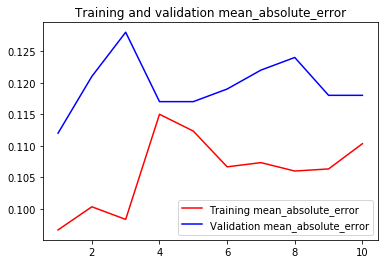

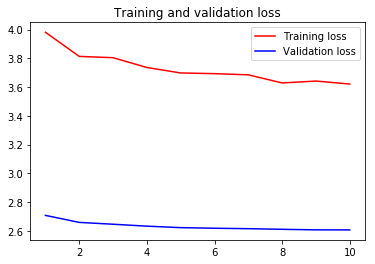

In [19]:
import matplotlib.pyplot as plt
def my_plot(h):  
    mae = h['acc']
    val_mae = h['val_acc']
    loss = h['loss']
    val_loss = h['val_loss']
    epochs = range(1,len(mae)+1)
    
    #acc, not mae here
    plt.plot(epochs,mae,'r',label='Training acc')
    plt.plot(epochs,val_mae,'b',label='Validation acc')
    plt.title('Training and validation acc')
    plt.legend()

    plt.figure()
    plt.plot(epochs,loss,'r',label='Training loss')
    plt.plot(epochs,val_loss,'b',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()
my_plot(history.history)

In [ ]:
def baseline_model():
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(10,activation='softmax',input_dim=2048,kernel_regularizer=regularizers.l2()))

    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
seed = 7
np.random.seed(seed)
estimator = KerasClassifier(build_fn=baseline_model, epochs=2, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, validation_images, encoded_validation_labels, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))